# NLP Methods on Music Reviews
This project explores text preprocessing, lexicon normalization, and modeling of music reviews, retrieved from the Kaggle dataset [song reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data)

In [1]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import sqlite3
import string, re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Khyatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Khyatee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Khyatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import Data
The data is stored as a series of tables within a sqlite database. The following cells extract each table and convert them to Pandas dataframes.

### Connect to the Database

In [2]:
connection = sqlite3.connect('datasets/reviews.sqlite')
cursor = connection.cursor()

### Reviews Table

In [3]:
query = "select * from reviews;"
cursor.execute(query)
df_reviews = pd.DataFrame(cursor.fetchall(), columns=["id",'track', 'artist', 'url','score',
    'best_new_music', 'author', 'author_type','date','weekday', 'day', 'month', 'year'])
df_reviews.head()

,id,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


### Content Table

In [4]:
query = "select * from content;"
cursor.execute(query)
df_content = pd.DataFrame(cursor.fetchall(), columns=["id",'review'])
df_content.head()

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


### Genres Table

In [5]:
query = "select * from genres;"
cursor.execute(query)
df_genres = pd.DataFrame(cursor.fetchall(), columns=["id",'genre'])
df_genres.head()

,id,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


## Merge Dataframes

In [6]:
df = df_content.merge(df_reviews, on='id')
df.head()

,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,"Eight years, five albums, and two EPs in, the ...",prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,Kleenex began with a crash. It transpired one ...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,It is impossible to consider a given release b...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


## Downsample
The dataset has imbalanced classes, so we use downsampling because we are dealing with text data, which is difficult to upsample

In [7]:
df.best_new_music.value_counts()

0    17458
1      943
Name: best_new_music, dtype: int64

### Take a random sample of 1000 observations from negative class

In [8]:
neg_class_indices = df[df['best_new_music'] == 0].index
random_indices = np.random.choice(neg_class_indices, 1000, replace=False)
neg_class_sample = df.loc[random_indices]


In [9]:
df = pd.concat([df[df['best_new_music'] == 1], neg_class_sample])
df = df.loc[:,['review', 'best_new_music']]
df.best_new_music.value_counts()

0    1000
1     943
Name: best_new_music, dtype: int64

In [145]:
df.iloc[942]

review            Language is for suckers, but due to the limita...
best_new_music                                                    1
Name: 16418, dtype: object

# Data Cleaning
The following cells perform text preprocessing steps, such as stop word / punctuation removal, and lexicon normalization

In [49]:
reviews = df['review']
target = df['best_new_music']

In [50]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Stopword Removal

In [91]:
## setting stopwords and punctuations
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)
stopword_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            "n't", "'s", "'re", '-', '–', '—','\r\n','\r','\n', '--']
stopword_set = set(stopword_list)


In [92]:
# define a function that removes stopwords
def remove_stopwords(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopword_set]
    return stopwords_removed 

# Bag of Words

In [97]:
df_freq_best = df[df['best_new_music']==1]
df_freq_not_best = df[df['best_new_music']==0]
df_freq_not_best

,review,best_new_music
5824,Goldfrapp have spent the past decade moving ba...,0
5582,"Glancing at her bio, you'd be forgiven for ass...",0
10996,For every artist that starts out with a solo h...,0
6508,Graham Wright plays an often-overlooked role (...,0
8776,"Wye Oak's debut, If Children, was a small, sur...",0
...,...,...
12765,The arrival of new material from Kawabata Mako...,0
9851,Reality used to be a friend of Game; these day...,0
11671,"After ""Oh My God"" dented the UK singles charts...",0
483,Toro Y Moi isn’t exactly the first artist you ...,0


In [98]:
best_reviews = df_freq_best['review']
not_best_reviews = df_freq_not_best['review']

### Remove Stopwords

In [99]:
best_reviews_no_stop = list(map(remove_stopwords, best_reviews))
not_best_reviews_no_stop = list(map(remove_stopwords, not_best_reviews))

In [100]:
total_vocab_best = set()
for word in best_reviews_no_stop:
    total_vocab_best.update(word)
len(total_vocab_best)

55630

In [101]:
total_vocab_NOT_best = set()
for word in not_best_reviews_no_stop:
    total_vocab_NOT_best.update(word)
len(total_vocab_NOT_best)

48331

### Flatten list of lists

In [102]:
flat_best_reviews = [item for sublist in best_reviews_no_stop for item in sublist]
flat_not_best_reviews = [item for sublist in not_best_reviews_no_stop for item in sublist]

In [103]:
best_freq = FreqDist(flat_best_reviews)
not_best_freq = FreqDist(flat_not_best_reviews)

### Most Common Words

In [104]:
best_freq.most_common(20)

[('like', 4461),
 ('album', 3493),
 ('music', 3110),
 ('one', 2742),
 ('band', 2359),
 ('songs', 2091),
 ('song', 1877),
 ('record', 1795),
 ('even', 1700),
 ('new', 1636),
 ('first', 1600),
 ('sound', 1580),
 ('time', 1555),
 ('way', 1290),
 ('also', 1268),
 ('much', 1202),
 ('sounds', 1184),
 ('would', 1180),
 ('two', 1168),
 ('rock', 1165)]

In [105]:
not_best_freq.most_common(20)

[('like', 3404),
 ('album', 2363),
 ('one', 1842),
 ('music', 1807),
 ('band', 1746),
 ('songs', 1558),
 ('sound', 1289),
 ('song', 1277),
 ('even', 1254),
 ('new', 1026),
 ('record', 1024),
 ('time', 1017),
 ('track', 961),
 ('much', 956),
 ('first', 941),
 ('sounds', 904),
 ('two', 886),
 ('guitar', 877),
 ('way', 871),
 ('tracks', 818)]

### Normalized Word Frequencies

In [106]:
best_reviews_total_word_count = sum(best_freq.values())
best_top_25 = best_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in best_top_25:
    normalized_frequency = word[1]/best_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.008578
album 		 0.006717
music 		 0.00598
one 		 0.005273
band 		 0.004536
songs 		 0.004021
song 		 0.003609
record 		 0.003452
even 		 0.003269
new 		 0.003146
first 		 0.003077
sound 		 0.003038
time 		 0.00299
way 		 0.002481
also 		 0.002438
much 		 0.002311
sounds 		 0.002277
would 		 0.002269
two 		 0.002246
rock 		 0.00224
could 		 0.002238
still 		 0.002119
pop 		 0.002011
love 		 0.00199
years 		 0.001983


In [107]:
not_best_reviews_total_word_count = sum(not_best_freq.values())
not_best_top_25 = not_best_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in not_best_top_25:
    normalized_frequency = word[1]/not_best_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.009206
album 		 0.006391
one 		 0.004982
music 		 0.004887
band 		 0.004722
songs 		 0.004213
sound 		 0.003486
song 		 0.003454
even 		 0.003391
new 		 0.002775
record 		 0.002769
time 		 0.00275
track 		 0.002599
much 		 0.002585
first 		 0.002545
sounds 		 0.002445
two 		 0.002396
guitar 		 0.002372
way 		 0.002356
tracks 		 0.002212
still 		 0.002201
would 		 0.002109
could 		 0.002066
though 		 0.00198
rock 		 0.001961


# Word Clouds

In [115]:
top_words_best = [x[0] for x in best_freq.most_common(25)]
top_words_best_count = [x[1] for x in best_freq.most_common(25)]

top_words_not_best = [x[0] for x in not_best_freq.most_common(25)]
top_words_not_best_count = [x[1] for x in not_best_freq.most_common(25)]

In [118]:
from wordcloud import WordCloud
best_dictionary = dict(zip(top_words_best, top_words_best_count))
not_best_dictionary = dict(zip(top_words_not_best, top_words_not_best_count))

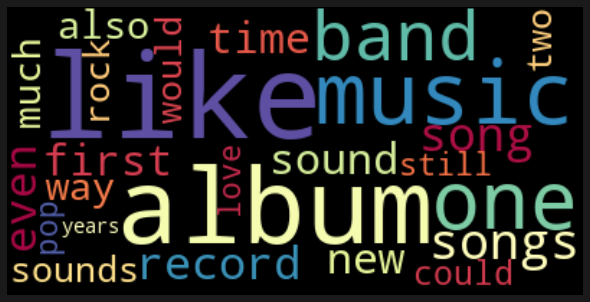

In [120]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(best_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

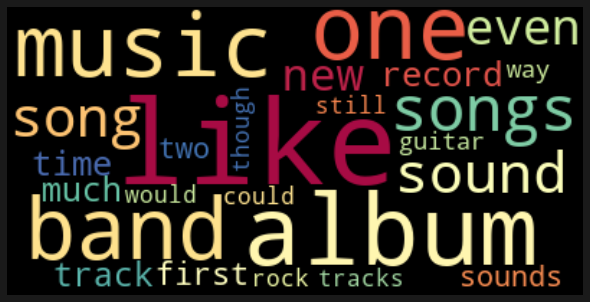

In [121]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_best_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Lexicon Normalization


In [53]:
# applying the above function to our features 
reviews_no_stop = list(map(remove_stopwords, reviews))


## Lemmatization
Create a list with all lemmatized outputs

In [93]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

lemmatized_output = []

for listt in reviews_no_stop:
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in listt])
    lemmatized_output.append(lemmed)

In [94]:
X_lem = lemmatized_output

y_lem = target

## Stemming

In [122]:
# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

stemmed_output = []
for listt in reviews_no_stop:
    stemmed = ' '.join([stemmer.stem(word) for word in listt])
    stemmed_output.append(stemmed)

In [123]:
X_stem = stemmed_output

y_stem = target

### Train/Test Split

In [150]:
# train test split the lemmatized words
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)

In [ ]:
# train test split the stemmed words
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem, test_size=0.20, random_state=1)


# TF-IDF

In [ ]:
tfidf = TfidfVectorizer()
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)


In [96]:
# get a quick look of the non zero elements

non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 363.04954954954957
Percentage of columns containing ZERO: 0.9915524687728424


# T-SNE

In [140]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(tfidf_data_train_stem)

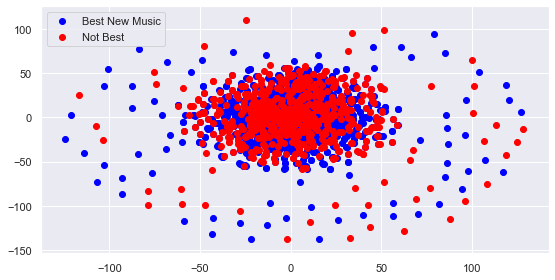

In [148]:
best_2d = X_embedded[:943]
best_x = [i[0] for i in best_2d]
best_y = [i[1] for i in best_2d]

not_best_2d = X_embedded[943:]
not_best_x = [i[0] for i in not_best_2d]
not_best_y = [i[1] for i in not_best_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(best_x, best_y, c='blue', label='Best New Music')
ax.scatter(not_best_x, not_best_y, c='red', label='Not Best')
ax.legend()
plt.show()

# Classification
## TFIDF and Lemming

In [108]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(tfidf_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(tfidf_data_test_lem)

In [110]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.7661

F1 Score: 0.7393


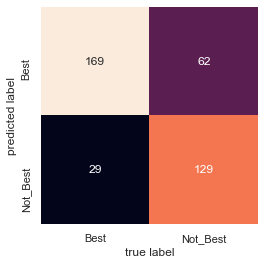

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, forest_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Best', 'Not_Best'], yticklabels=['Best', 'Not_Best'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## TFIDF and Stemming


In [149]:
tfidf = TfidfVectorizer()
tfidf_data_train_stem = tfidf.fit_transform(X_train_stem)
tfidf_data_test_stem = tfidf.transform(X_test_stem)

### Random Forest

In [126]:
forest_stem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_stem.fit(tfidf_data_train_stem, y_train_stem)
forest_test_preds_stem = forest_stem.predict(tfidf_data_test_stem)

In [127]:
forest_acc_score_stem = accuracy_score(y_test_stem, forest_test_preds_stem)
forest_f1_score_stem = f1_score(y_test_stem, forest_test_preds_stem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_stem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_stem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.7506

F1 Score: 0.7236


## Count Vectorizer

In [128]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words=stopword_list)
vec_data_train_lem = vec.fit_transform(X_train_lem)
vec_data_test_lem = vec.transform(X_test_lem)

In [129]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(vec_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(vec_data_test_lem)

In [130]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.7686

F1 Score: 0.7472
